In [98]:
from sklearn.datasets import make_circles

In [99]:
n_samples = 1000

x,y = make_circles(n_samples, noise=0.03, random_state=42)

In [100]:
import pandas as pd

circles = pd.DataFrame({"X1":x[:,0],
                        "X2":x[:,1],
                        "label":y})

circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


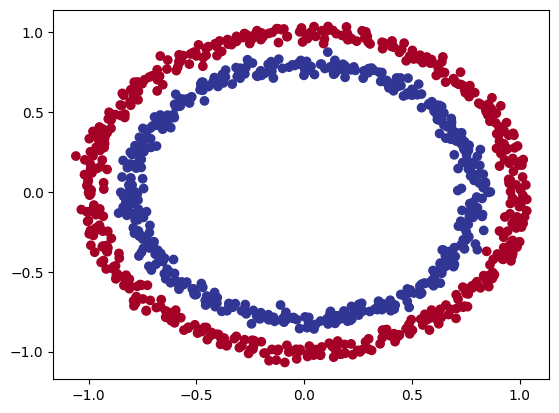

In [101]:
import matplotlib.pyplot as plt

plt.scatter(x=x[:,0],
            y=x[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [102]:
import torch

X = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [103]:
from torch import nn
device = "cuda" if torch.cuda.is_available() else 'cpu'

In [104]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=1)

    def forward(self,x:torch.tensor):
        return self.layer2(self.layer1(x))
    
model0 = CircleModelV0().to(device)
model0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=1, bias=True)
)

In [105]:
model1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [106]:
loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.SGD(params=model0.parameters(),lr=0.1)

In [107]:
def accuracy(y_pred,y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    return (correct/len(y_true))*100

In [108]:
y_logits = model0(X_test.to(device))[:5]
y_pred_prob = torch.sigmoid(y_logits)

In [109]:
y_preds_labels = torch.round(y_pred_prob)
y_preds_labels.squeeze()

tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [110]:
torch.manual_seed(42)

epochs = 1000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):

    model0.train()

    y_logits = model0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_pred, y_train)

    opt.zero_grad()

    loss.backward()

    opt.step()

    model0.eval()

    with torch.inference_mode():
        test_logits = model0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        loss_test = loss_fn(test_logits, y_test)
        acc_test = accuracy(test_pred, y_test)
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}| Loss(Training): {loss:.5f}| Accuracy(Training): {acc:.2f}%| Loss(Testing): {loss_test:.5f}| Accuracy(Testing): {acc_test:.2f}%")

Epoch: 0| Loss(Training): 0.71679| Accuracy(Training): 50.00%| Loss(Testing): 0.71061| Accuracy(Testing): 50.00%
Epoch: 10| Loss(Training): 0.69854| Accuracy(Training): 50.00%| Loss(Testing): 0.69799| Accuracy(Testing): 50.00%
Epoch: 20| Loss(Training): 0.69482| Accuracy(Training): 55.25%| Loss(Testing): 0.69573| Accuracy(Testing): 55.00%
Epoch: 30| Loss(Training): 0.69385| Accuracy(Training): 52.00%| Loss(Testing): 0.69521| Accuracy(Testing): 51.50%
Epoch: 40| Loss(Training): 0.69348| Accuracy(Training): 51.62%| Loss(Testing): 0.69499| Accuracy(Testing): 49.00%
Epoch: 50| Loss(Training): 0.69328| Accuracy(Training): 51.25%| Loss(Testing): 0.69486| Accuracy(Testing): 48.00%
Epoch: 60| Loss(Training): 0.69317| Accuracy(Training): 50.75%| Loss(Testing): 0.69476| Accuracy(Testing): 51.00%
Epoch: 70| Loss(Training): 0.69310| Accuracy(Training): 50.75%| Loss(Testing): 0.69470| Accuracy(Testing): 47.50%
Epoch: 80| Loss(Training): 0.69306| Accuracy(Training): 51.00%| Loss(Testing): 0.69466| A

helper_functions.py already exists, skipping download


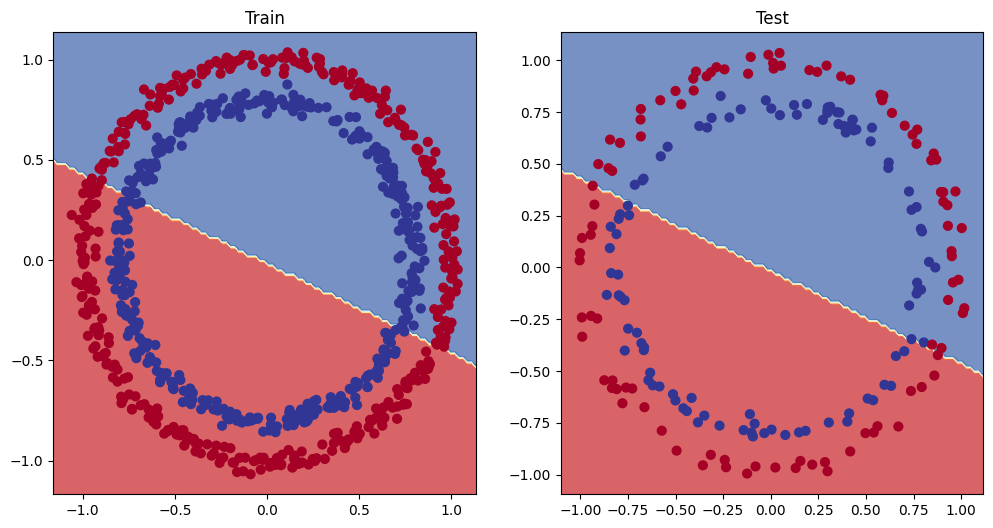

In [111]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)

In [112]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self,x):
        return self.layer3(self.relu(self.layer2(self.layer1(x))))

In [113]:
model2 = CircleModelV1().to(device)
print(model2)

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [114]:
opt = torch.optim.SGD(params=model2.parameters(), lr=0.1)
loss_fn = nn.BCEWithLogitsLoss()

In [115]:
torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    
    model2.train()
    
    y_logits = model2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_pred, y_train)

    opt.zero_grad()
    loss.backward()

    opt.step()

    model2.eval()

    with torch.inference_mode():
        y_pred_test_logits = model2(X_test).squeeze()
        y_pred_test_probs = torch.round(torch.sigmoid(y_pred_test_logits))
        loss_test = loss_fn(y_pred_test_logits, y_test)
        acc_test = accuracy(y_pred_test_probs, y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}| Loss(Training): {loss:.5f}| Accuracy(Training): {acc:.2f}%| Loss(Testing): {loss_test:.5f}| Accuracy(Testing): {acc_test:.2f}%")

Epoch: 0| Loss(Training): 0.69833| Accuracy(Training): 50.00%| Loss(Testing): 0.69863| Accuracy(Testing): 49.00%
Epoch: 10| Loss(Training): 0.69697| Accuracy(Training): 49.62%| Loss(Testing): 0.69757| Accuracy(Testing): 49.50%
Epoch: 20| Loss(Training): 0.69618| Accuracy(Training): 49.62%| Loss(Testing): 0.69700| Accuracy(Testing): 49.50%
Epoch: 30| Loss(Training): 0.69558| Accuracy(Training): 49.38%| Loss(Testing): 0.69654| Accuracy(Testing): 48.50%
Epoch: 40| Loss(Training): 0.69498| Accuracy(Training): 49.75%| Loss(Testing): 0.69609| Accuracy(Testing): 48.00%
Epoch: 50| Loss(Training): 0.69453| Accuracy(Training): 50.25%| Loss(Testing): 0.69578| Accuracy(Testing): 48.50%
Epoch: 60| Loss(Training): 0.69418| Accuracy(Training): 49.62%| Loss(Testing): 0.69550| Accuracy(Testing): 47.50%
Epoch: 70| Loss(Training): 0.69386| Accuracy(Training): 50.25%| Loss(Testing): 0.69519| Accuracy(Testing): 47.00%
Epoch: 80| Loss(Training): 0.69354| Accuracy(Training): 50.12%| Loss(Testing): 0.69487| A

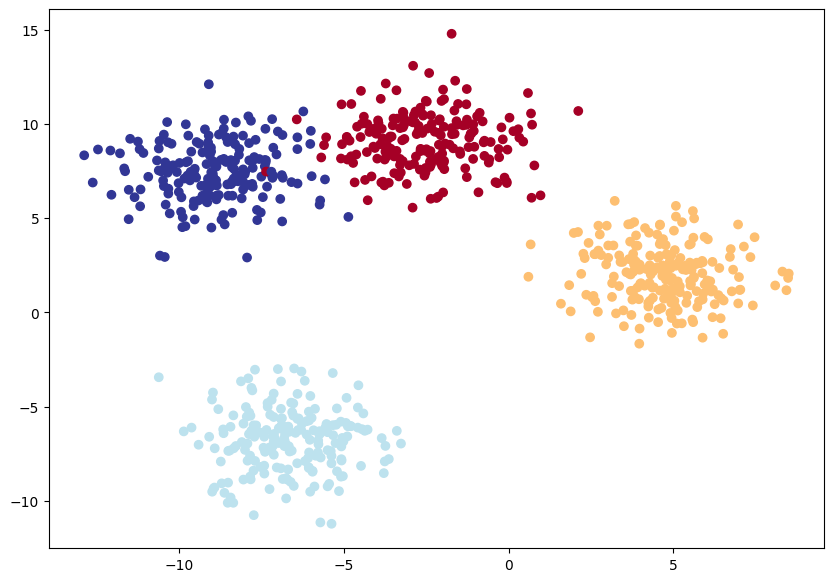

In [134]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=plt.cm.RdYlBu)

In [145]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self,x):
        return self.linear_layer_stack(x)
    
model3 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES).to(device)
model3

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [146]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model3.parameters(), lr=0.1)

In [148]:
torch.manual_seed(42)
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):

    model3.train()
    y_logits = model3(X_train).to(device)
    y_logits_probs = torch.softmax(y_logits, dim=1).argmax(dim=1).to(device)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_logits_probs, y_train)

    opt.zero_grad()
    loss.backward()

    opt.step()

    model3.eval()
    with torch.inference_mode():
        y_logits_test = model3(X_test).squeeze()
        y_logits_test_probs = torch.softmax(y_logits_test, dim=1).argmax(dim=1)

        loss_test = loss_fn(y_logits_test, y_test)
        acc_test = accuracy(y_logits_test_probs, y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}| Loss(Training): {loss:.5f}| Accuracy(Training): {acc:.2f}%| Loss(Testing): {loss_test:.5f}| Accuracy(Testing): {acc_test:.2f}%")

Epoch: 0| Loss(Training): 0.03185| Accuracy(Training): 99.12%| Loss(Testing): 0.02293| Accuracy(Testing): 99.50%
Epoch: 10| Loss(Training): 0.03093| Accuracy(Training): 99.12%| Loss(Testing): 0.02186| Accuracy(Testing): 99.50%
Epoch: 20| Loss(Training): 0.03017| Accuracy(Training): 99.12%| Loss(Testing): 0.02097| Accuracy(Testing): 99.50%
Epoch: 30| Loss(Training): 0.02955| Accuracy(Training): 99.12%| Loss(Testing): 0.02022| Accuracy(Testing): 99.50%
Epoch: 40| Loss(Training): 0.02902| Accuracy(Training): 99.12%| Loss(Testing): 0.01958| Accuracy(Testing): 99.50%
Epoch: 50| Loss(Training): 0.02857| Accuracy(Training): 99.12%| Loss(Testing): 0.01902| Accuracy(Testing): 99.50%
Epoch: 60| Loss(Training): 0.02819| Accuracy(Training): 99.12%| Loss(Testing): 0.01852| Accuracy(Testing): 99.50%
Epoch: 70| Loss(Training): 0.02785| Accuracy(Training): 99.12%| Loss(Testing): 0.01809| Accuracy(Testing): 99.50%
Epoch: 80| Loss(Training): 0.02756| Accuracy(Training): 99.12%| Loss(Testing): 0.01770| A

In [150]:
model3.eval()
with torch.inference_mode():
    y_logits = model3(X_train)

y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

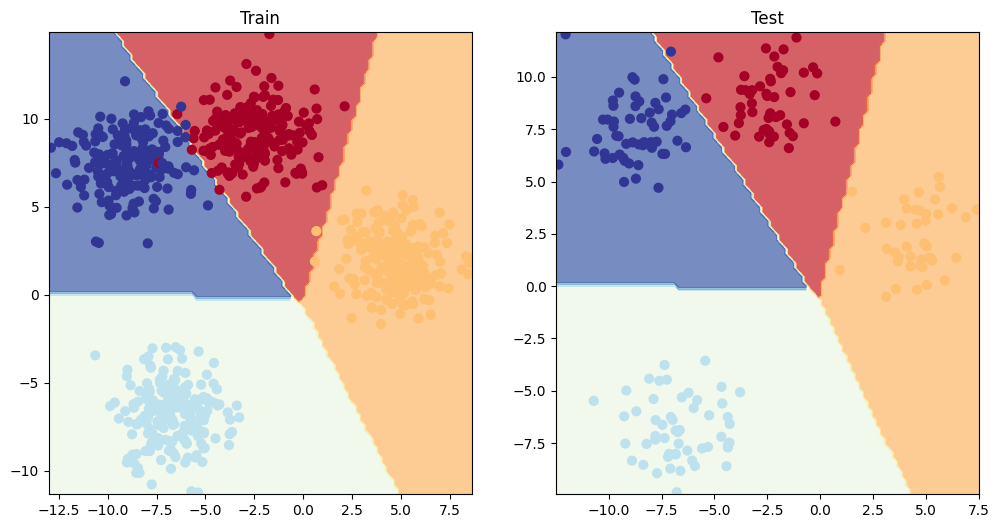

In [151]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model3, X_test, y_test)

In [154]:
from sklearn.metrics import classification_report
sklearn.metrics.classification_report(y_true=y_train.cpu(), y_pred=y_pred.cpu())

'              precision    recall  f1-score   support\n\n           0       0.98      0.99      0.98       201\n           1       1.00      1.00      1.00       209\n           2       1.00      1.00      1.00       197\n           3       0.98      0.98      0.98       193\n\n    accuracy                           0.99       800\n   macro avg       0.99      0.99      0.99       800\nweighted avg       0.99      0.99      0.99       800\n'